In [ ]:
!pip install pyspark

from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, when, col, lit, avg, isnan, count, corr

from google.colab import drive
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, f1_score, auc, roc_curve

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd

from pyspark.sql.functions import col
from sklearn.svm import NuSVC

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier

from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.stat import Summarizer

In [ ]:
# Langkah 1: Mount Google Drive
drive.mount('/content/drive')

# Langkah 2: Inisialisasi SparkSession
spark = SparkSession.builder \
    .appName("Ovarian Cancer Classification") \
    .getOrCreate()

# Langkah 3: Membaca file CSV dengan delimiter ';'
file_path = '/content/drive/MyDrive/BDL/Obesity_prediction.csv'
pyspark_df = spark.read.csv(
    file_path,
    header=True,
    inferSchema=True,
    sep=","  # Menggunakan delimiter ';'
)


# Langkah 5: Menampilkan data
pyspark_df.show()


Mounted at /content/drive
+------+----+------+------+--------------+----+----+---+----------+-----+----+---+---+---+----------+--------------------+-------------------+
|Gender| Age|Height|Weight|family_history|FAVC|FCVC|NCP|      CAEC|SMOKE|CH2O|SCC|FAF|TUE|      CALC|              MTRANS|            Obesity|
+------+----+------+------+--------------+----+----+---+----------+-----+----+---+---+---+----------+--------------------+-------------------+
|Female|21.0|  1.62|  64.0|           yes|  no| 2.0|3.0| Sometimes|   no| 2.0| no|0.0|1.0|        no|Public_Transporta...|      Normal_Weight|
|Female|21.0|  1.52|  56.0|           yes|  no| 3.0|3.0| Sometimes|  yes| 3.0|yes|3.0|0.0| Sometimes|Public_Transporta...|      Normal_Weight|
|  Male|23.0|   1.8|  77.0|           yes|  no| 2.0|3.0| Sometimes|   no| 2.0| no|2.0|1.0|Frequently|Public_Transporta...|      Normal_Weight|
|  Male|27.0|   1.8|  87.0|            no|  no| 3.0|3.0| Sometimes|   no| 2.0| no|2.0|0.0|Frequently|             Wa

In [ ]:
pyspark_df.printSchema()

root
 |-- Gender: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Height: double (nullable = true)
 |-- Weight: double (nullable = true)
 |-- family_history: string (nullable = true)
 |-- FAVC: string (nullable = true)
 |-- FCVC: double (nullable = true)
 |-- NCP: double (nullable = true)
 |-- CAEC: string (nullable = true)
 |-- SMOKE: string (nullable = true)
 |-- CH2O: double (nullable = true)
 |-- SCC: string (nullable = true)
 |-- FAF: double (nullable = true)
 |-- TUE: double (nullable = true)
 |-- CALC: string (nullable = true)
 |-- MTRANS: string (nullable = true)
 |-- Obesity: string (nullable = true)



In [ ]:
# Total baris
total_rows = pyspark_df.count()

# Hitung jumlah nilai null di setiap kolom
null_counts = pyspark_df.select(
    [(count(when(col(c).isNull() | isnan(c), c)).alias(c)) for c in pyspark_df.columns]
).collect()[0]

# Tampilkan informasi kolom
print("\nColumn Summary:")
print(f"{'Column':<20} {'Type':<15} {'Null Count':<15}")
print("-" * 50)
for col_name, col_type, null_count in zip(pyspark_df.columns, pyspark_df.dtypes, null_counts):
    print(f"{col_name:<20} {col_type[1]:<15} {null_count:<15}")

# Total baris
print("-" * 50)
print(f"Total Rows: {total_rows}")


Column Summary:
Column               Type            Null Count     
--------------------------------------------------
Gender               string          0              
Age                  double          0              
Height               double          0              
Weight               double          0              
family_history       string          0              
FAVC                 string          0              
FCVC                 double          0              
NCP                  double          0              
CAEC                 string          0              
SMOKE                string          0              
CH2O                 double          0              
SCC                  string          0              
FAF                  double          0              
TUE                  double          0              
CALC                 string          0              
MTRANS               string          0              
Obesity              string    

In [ ]:
# Mengganti nilai pada kolom 'Gender'
pyspark_df = pyspark_df.withColumn(
    "Gender",
    when(col("Gender") == "Male", 1)
    .when(col("Gender") == "Female", 2)
    .otherwise(None)  # Opsional: Menangani nilai selain 'Male' dan 'Female'
)

# Mengganti nilai pada kolom 'family_history'
pyspark_df = pyspark_df.withColumn(
    "family_history",
    when(col("family_history") == "yes", 1)
    .when(col("family_history") == "no", 0)
    .otherwise(None)  # Opsional: Menangani nilai selain 'yes', dan 'no'
)

# Mengganti nilai pada kolom 'FAVC'
pyspark_df = pyspark_df.withColumn(
    "FAVC",
    when(col("FAVC") == "yes", 1)
    .when(col("FAVC") == "no", 0)
    .otherwise(None)  # Opsional: Menangani nilai selain 'yes', dan 'no'
)

# Mengganti nilai pada kolom 'CAEC'
pyspark_df = pyspark_df.withColumn(
    "CAEC",
    when(col("CAEC") == "no", 0)
    .when(col("CAEC") == "Sometimes", 1)
    .when(col("CAEC") == "Frequently", 2)
    .when(col("CAEC") == "Always", 3)
    .otherwise(None)  # Opsional: Menangani nilai selain 'no', 'Sometimes', 'Frequently', dan 'Always'
)

# Mengganti nilai pada kolom 'SMOKE'
pyspark_df = pyspark_df.withColumn(
    "SMOKE",
    when(col("SMOKE") == "yes", 1)
    .when(col("SMOKE") == "no", 0)
    .otherwise(None)  # Opsional: Menangani nilai selain 'yes', dan 'no'
)

# Mengganti nilai pada kolom 'SCC'
pyspark_df = pyspark_df.withColumn(
    "SCC",
    when(col("SCC") == "yes", 1)
    .when(col("SCC") == "no", 0)
    .otherwise(None)  # Opsional: Menangani nilai selain 'yes', dan 'no'
)

# Mengganti nilai pada kolom 'CALC'
pyspark_df = pyspark_df.withColumn(
    "CALC",
    when(col("CALC") == "no", 0)
    .when(col("CALC") == "Sometimes", 1)
    .when(col("CALC") == "Frequently", 2)
    .when(col("CALC") == "Always", 3)
    .otherwise(None)  # Opsional: Menangani nilai selain 'no', 'Sometimes', 'Frequently', dan 'Always'
)

# Mengganti nilai pada kolom 'MTRANS'
pyspark_df = pyspark_df.withColumn(
    "MTRANS",
    when(col("MTRANS") == "Public_Transportation", 1)
    .when(col("MTRANS") == "Automobile", 2)
    .when(col("MTRANS") == "Motorbike", 3)
    .when(col("MTRANS") == "Bike", 4)
    .when(col("MTRANS") == "Walking", 5)
    .otherwise(None)  # Opsional: Menangani nilai selain 'Public_Transportation', 'Automobile', 'Motorbike', 'Bike', dan 'Walking'
)

# Mengganti nilai pada kolom 'Obesity'
pyspark_df = pyspark_df.withColumn(
    "Obesity",
    when(col("Obesity") == "Insufficient_Weight", 0)
    .when(col("Obesity") == "Normal_Weight", 1)
    .when(col("Obesity") == "Overweight_Level_I", 2)
    .when(col("Obesity") == "Overweight_Level_II", 3)
    .when(col("Obesity") == "Obesity_Type_I", 4)
    .when(col("Obesity") == "Obesity_Type_II", 5)
    .when(col("Obesity") == "Obesity_Type_III", 6)
    .otherwise(None)  # Opsional: Menangani nilai selain 'Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', dan 'Obesity_Type_III'
)

In [ ]:
# Daftar kolom yang ingin dikonversi
columns_to_convert = ['Gender', 'family_history', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'Obesity']

# Konversi kolom ke tipe numerik (double)
for col_name in columns_to_convert:
    pyspark_df = pyspark_df.withColumn(col_name, col(col_name).cast('int'))

# Tampilkan informasi kolom
print("\nColumn Summary:")
print(f"{'Column':<20} {'Type':<15} {'Null Count':<15}")
print("-" * 50)
for col_name, col_type, null_count in zip(pyspark_df.columns, pyspark_df.dtypes, null_counts):
    print(f"{col_name:<20} {col_type[1]:<15} {null_count:<15}")

# Total baris
print("-" * 50)


Column Summary:
Column               Type            Null Count     
--------------------------------------------------
Gender               int             0              
Age                  double          0              
Height               double          0              
Weight               double          0              
family_history       int             0              
FAVC                 int             0              
FCVC                 double          0              
NCP                  double          0              
CAEC                 int             0              
SMOKE                int             0              
CH2O                 double          0              
SCC                  int             0              
FAF                  double          0              
TUE                  double          0              
CALC                 int             0              
MTRANS               int             0              
Obesity              int       

In [ ]:
from pyspark.sql.functions import count, col

# Count duplicate rows based on all columns
duplicate_count = pyspark_df.groupBy(pyspark_df.columns).count().filter(col("count") > 1).count()

print("Duplicate Values =", duplicate_count)

# Drop duplicate rows
pyspark_df = pyspark_df.dropDuplicates()

# Verify duplicates have been removed
duplicate_count_after_drop = pyspark_df.groupBy(pyspark_df.columns).count().filter(col("count") > 1).count()

print("Duplicate Values After Drop =", duplicate_count_after_drop)

Duplicate Values = 9
Duplicate Values After Drop = 0


In [ ]:
# Buat kolom baru `Status` dengan kondisi
pyspark_df = pyspark_df.withColumn(
    "Status",
    when(
        (col("Obesity") == 0) | (col("Obesity") == 1),  # Kondisi untuk Insufficient_Weight dan Normal_Weight
        0
    ).otherwise(
        1  # Kondisi untuk Overweight_Level_I, Overweight_Level_II, Obesity_Type_I, Obesity_Type_II, Obesity_Type_III
    ).cast("int")  # Mengubah tipe data menjadi int
)

In [ ]:
pyspark_df.show()  # Menampilkan beberapa baris data untuk melihat kolom Status

+------+---------+--------+----------+--------------+----+--------+--------+----+-----+--------+---+--------+--------+----+------+-------+------+
|Gender|      Age|  Height|    Weight|family_history|FAVC|    FCVC|     NCP|CAEC|SMOKE|    CH2O|SCC|     FAF|     TUE|CALC|MTRANS|Obesity|Status|
+------+---------+--------+----------+--------------+----+--------+--------+----+-----+--------+---+--------+--------+----+------+-------+------+
|     1|     21.0|    1.75|      62.0|             0|   1|     3.0|     4.0|   2|    1|     2.0|  0|     0.0|     0.0|   1|     1|      1|     0|
|     2|     30.0|    1.65|      71.0|             1|   1|     2.0|     3.0|   1|    0|     1.0|  0|     0.0|     0.0|   1|     1|      2|     1|
|     1|18.128249|1.699437|  52.08657|             1|   1|2.853513|     3.0|   1|    0|     2.0|  0|0.680464|1.258881|   1|     1|      0|     0|
|     2|28.770852|1.532897| 65.031879|             1|   0|     2.0|     1.0|   1|    0|     1.0|  0|0.262171|     0.0|   0| 

#Split Data & Seleksi Fitur

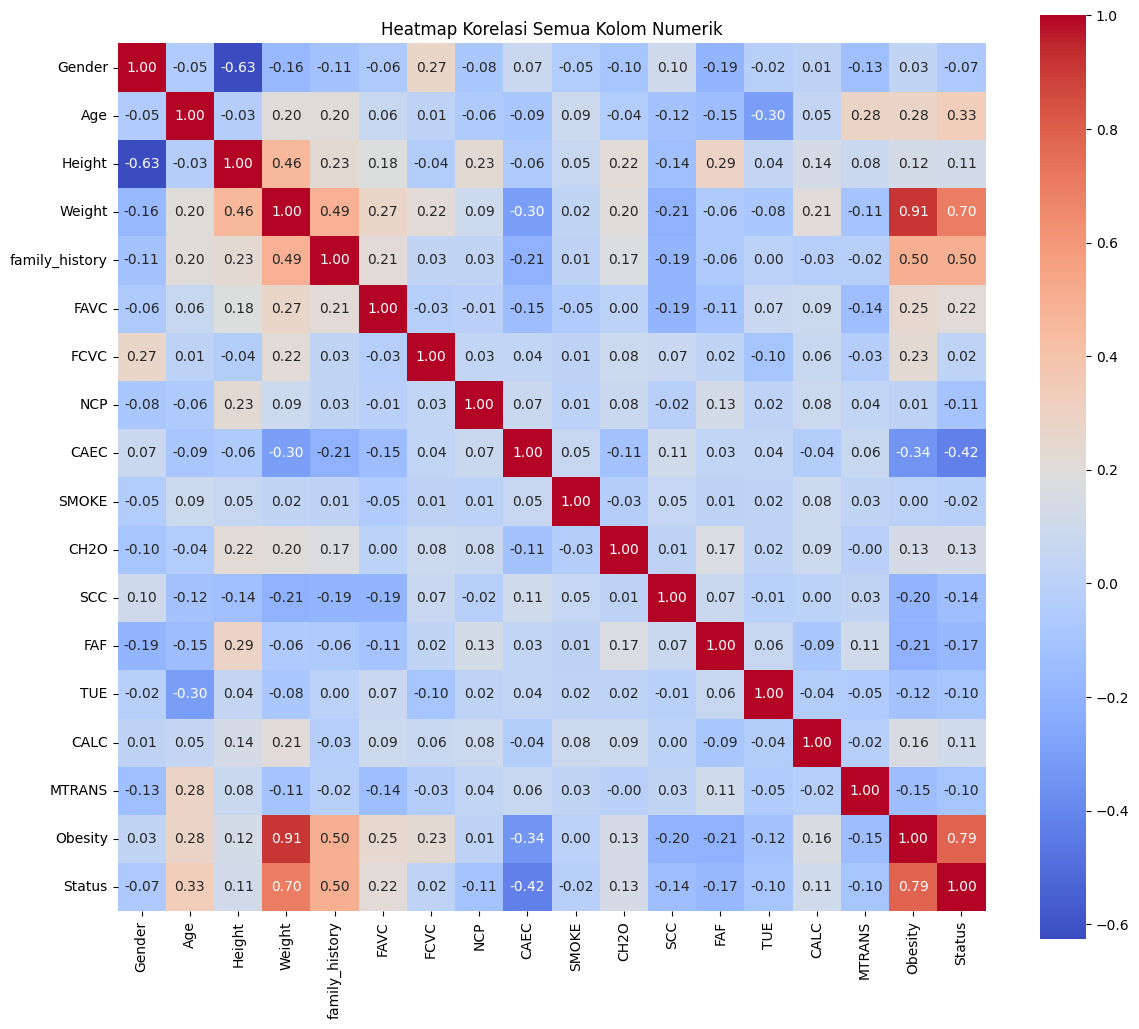

In [ ]:
# Ambil semua kolom numerik dari DataFrame
numeric_columns = [col_name for col_name, dtype in pyspark_df.dtypes if dtype in ('int', 'double')]

# Hitung korelasi antar semua kolom numerik
correlation_data = []
for col1 in numeric_columns:
    row = []
    for col2 in numeric_columns:
        corr_value = pyspark_df.select(corr(col1, col2)).collect()[0][0]  # Hitung korelasi
        row.append(float(corr_value) if corr_value is not None else np.nan)
    correlation_data.append(row)

# Konversi hasil korelasi ke Pandas DataFrame
correlation_df = pd.DataFrame(correlation_data, columns=numeric_columns, index=numeric_columns)

correlation_df = correlation_df.fillna(0)

# Visualisasi menggunakan Seaborn heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Heatmap Korelasi Semua Kolom Numerik")
plt.show()

In [ ]:
# Filter fitur berdasarkan threshold korelasi
threshold = 0.1
selected_features = []
for col in correlation_df.columns:
    if abs(correlation_df.loc['Obesity', col]) > threshold and col != 'Obesity':
        selected_features.append(col)

print(f"Fitur terpilih: {selected_features}")

# Membuat DataFrame baru dengan fitur terpilih dan kolom 'Obesity'
selected_pyspark_df = pyspark_df.select(selected_features + ['Obesity'])
selected_pyspark_df.show()

num_selected_features = len(selected_features)
print(f"Jumlah kolom terpilih: {num_selected_features}")

Fitur terpilih: ['Age', 'Height', 'Weight', 'family_history', 'FAVC', 'FCVC', 'CAEC', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'Status']
+---------+--------+----------+--------------+----+--------+----+--------+---+--------+--------+----+------+------+-------+
|      Age|  Height|    Weight|family_history|FAVC|    FCVC|CAEC|    CH2O|SCC|     FAF|     TUE|CALC|MTRANS|Status|Obesity|
+---------+--------+----------+--------------+----+--------+----+--------+---+--------+--------+----+------+------+-------+
|     21.0|    1.75|      62.0|             0|   1|     3.0|   2|     2.0|  0|     0.0|     0.0|   1|     1|     0|      1|
|     30.0|    1.65|      71.0|             1|   1|     2.0|   1|     1.0|  0|     0.0|     0.0|   1|     1|     1|      2|
|18.128249|1.699437|  52.08657|             1|   1|2.853513|   1|     2.0|  0|0.680464|1.258881|   1|     1|     0|      0|
|28.770852|1.532897| 65.031879|             1|   0|     2.0|   1|     1.0|  0|0.262171|     0.0|   0|     1|     

In [ ]:
# Asumsikan 'Status' adalah kolom target Anda
X = pyspark_df.select(selected_features)  # Select the features from the original DataFrame
y = pyspark_df.select('Status').toPandas()['Status']  # Target

In [ ]:
# Split data sekali untuk semua model
train_data, test_data = pyspark_df.randomSplit([0.8, 0.2], seed=42)

# Tampilkan ukuran data train dan test
print(f"Jumlah data training: {train_data.count()}")
print(f"Jumlah data testing: {test_data.count()}")

Jumlah data training: 1716
Jumlah data testing: 371


In [ ]:
from pyspark.sql.functions import col, count

# Hitung jumlah data dengan Status = 0 pada data training
count_0_train = train_data.filter(col("Status") == 0).count()

# Hitung jumlah data dengan Status = 1 pada data training
count_1_train = train_data.filter(col("Status") == 1).count()

# Tampilkan hasilnya
print(f"Jumlah data dengan Status = 0 pada data training: {count_0_train}")
print(f"Jumlah data dengan Status = 1 pada data training: {count_1_train}")

Jumlah data dengan Status = 0 pada data training: 459
Jumlah data dengan Status = 1 pada data training: 1257


In [ ]:
from pyspark.sql.functions import col
from pyspark.sql import DataFrame

# Pisahkan data berdasarkan label
class_0 = train_data.filter(col("Status") == 0)
class_1 = train_data.filter(col("Status") == 1)

# Hitung jumlah data di kelas minoritas
minority_count = class_0.count()

# Undersample kelas mayoritas
class_1_undersampled = class_1.sample(fraction=minority_count / class_1.count(), seed=42)

# Gabungkan kembali
balanced_train_data = class_0.union(class_1_undersampled)

In [ ]:
# Jumlah data setelah undersampling
print("Jumlah data setelah undersampling:")
print(f"Jumlah kelas 0 (minoritas): {class_0.count()}")
print(f"Jumlah kelas 1 (mayoritas, setelah undersampling): {class_1_undersampled.count()}")

Jumlah data setelah undersampling:
Jumlah kelas 0 (minoritas): 459
Jumlah kelas 1 (mayoritas, setelah undersampling): 491


In [ ]:
balanced_train_data.groupBy("Status").count().show()

+------+-----+
|Status|count|
+------+-----+
|     0|  459|
|     1|  491|
+------+-----+



#My Random Forest

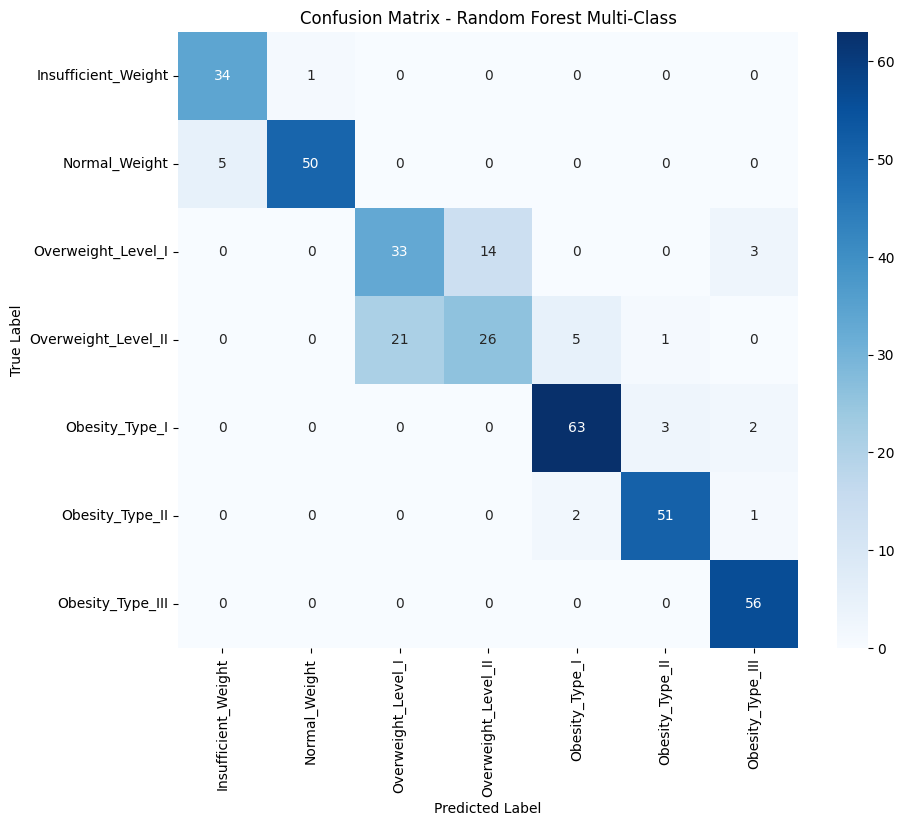

Classification Report:
                      precision    recall  f1-score   support

Insufficient_Weight       0.87      0.97      0.92        35
      Normal_Weight       0.98      0.91      0.94        55
 Overweight_Level_I       0.61      0.66      0.63        50
Overweight_Level_II       0.65      0.49      0.56        53
     Obesity_Type_I       0.90      0.93      0.91        68
    Obesity_Type_II       0.93      0.94      0.94        54
   Obesity_Type_III       0.90      1.00      0.95        56

           accuracy                           0.84       371
          macro avg       0.83      0.84      0.84       371
       weighted avg       0.84      0.84      0.84       371

Train ACC	: 0.8436657681940701
F1 Score	: 0.838775583380797
ROC		: 0.91


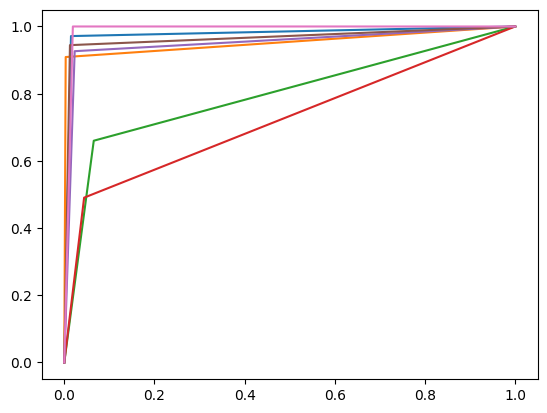

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Assembler untuk menggabungkan fitur
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")

# 2. Model Random Forest
rf = RandomForestClassifier(
    labelCol="Obesity",
    featuresCol="features",
    numTrees=50,       # Kurangi jumlah pohon
    maxDepth=5,        # Batasi kedalaman maksimum pohon
    minInstancesPerNode=10  # Minimum sampel per node
)

# 3. Pipeline untuk Random Forest
pipeline_rf = Pipeline(stages=[assembler, rf])

# 4. Melatih model menggunakan data undersampling
rf_model = pipeline_rf.fit(balanced_train_data)

# 5. Evaluasi tetap menggunakan test_data asli
predictions_rf = rf_model.transform(test_data)

# 6. Evaluator untuk Accuracy dan F1 Score
multi_evaluator = MulticlassClassificationEvaluator(
    labelCol="Obesity", predictionCol="prediction"
)

# Evaluasi Akurasi
accuracy_rf = multi_evaluator.evaluate(predictions_rf, {multi_evaluator.metricName: "accuracy"})

# Evaluasi F1 Score
f1_rf = multi_evaluator.evaluate(predictions_rf, {multi_evaluator.metricName: "f1"})

# 7. Konversi ke Pandas untuk evaluasi lanjutan
predictions_rf_pd = predictions_rf.select("prediction", "Obesity").toPandas()

# Confusion Matrix
conf_matrix = confusion_matrix(predictions_rf_pd["Obesity"], predictions_rf_pd["prediction"])

# Instead of using binary_evaluator, calculate ROC AUC for multiclass using sklearn
# You'll need to one-hot encode your target variable for this
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

y_test_binarized = label_binarize(predictions_rf_pd["Obesity"], classes=np.unique(predictions_rf_pd["Obesity"]))
y_pred_binarized = label_binarize(predictions_rf_pd["prediction"], classes=np.unique(predictions_rf_pd["Obesity"]))
roc_auc_rf = roc_auc_score(y_test_binarized, y_pred_binarized, average='weighted', multi_class='ovr') # Use 'ovr' for multiclass ROC AUC

# Visualisasi Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Insufficient_Weight", "Normal_Weight", "Overweight_Level_I",
                 "Overweight_Level_II", "Obesity_Type_I", "Obesity_Type_II",
                 "Obesity_Type_III"],  # Ganti dengan label kelas Anda
    yticklabels=["Insufficient_Weight", "Normal_Weight", "Overweight_Level_I",
                 "Overweight_Level_II", "Obesity_Type_I", "Obesity_Type_II",
                 "Obesity_Type_III"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest Multi-Class")
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(
    predictions_rf_pd["Obesity"], predictions_rf_pd["prediction"],
    target_names=["Insufficient_Weight", "Normal_Weight", "Overweight_Level_I",
                  "Overweight_Level_II", "Obesity_Type_I", "Obesity_Type_II",
                  "Obesity_Type_III"]
))

# 8. Output evaluasi
print('=============================================================')
print(f'Train ACC\t: {accuracy_rf}')
print(f'F1 Score\t: {f1_rf}')
print(f"ROC\t\t: {roc_auc_rf:.2f}")
print('=============================================================')

roc_auc_rf = []
for i in range(y_test_binarized.shape[1]):
    roc_auc_rf.append(roc_auc_score(y_test_binarized[:, i], y_pred_binarized[:, i]))
for i, class_name in enumerate(np.unique(predictions_rf_pd["Obesity"])):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc_rf[i]:.2f})')  # Now roc_auc_rf is a list


#NuSVC

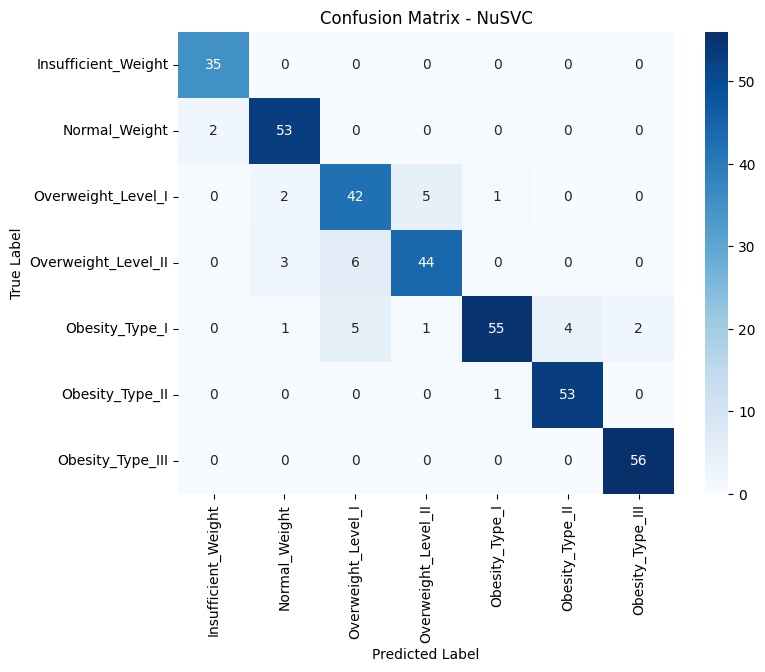

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.95      1.00      0.97        35
      Normal_Weight       0.90      0.96      0.93        55
     Obesity_Type_I       0.96      0.81      0.88        68
    Obesity_Type_II       0.93      0.98      0.95        54
   Obesity_Type_III       0.97      1.00      0.98        56
 Overweight_Level_I       0.79      0.84      0.82        50
Overweight_Level_II       0.88      0.83      0.85        53

           accuracy                           0.91       371
          macro avg       0.91      0.92      0.91       371
       weighted avg       0.91      0.91      0.91       371

Train ACC	: 0.91
Test ACC	: 0.91
F1		: 0.93
ACC cross val 5 : 0.9088702734340218
ROC AUC		: 0.99


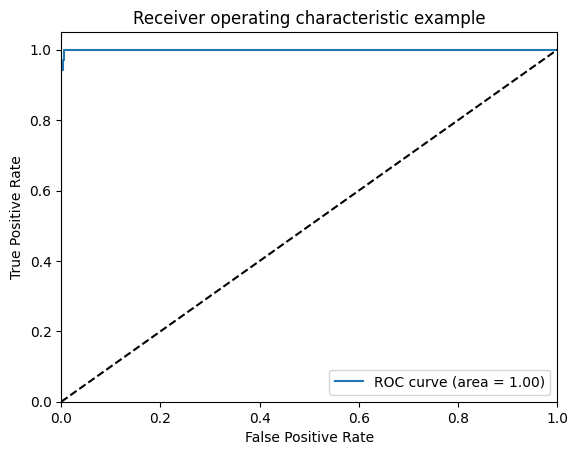

In [ ]:
# 1. Konversi train_data dan test_data dari PySpark ke Pandas
train_pandas = train_data.toPandas()
test_pandas = test_data.toPandas()

# 2. Pisahkan fitur dan target
X_train = train_pandas[selected_features]
y_train = train_pandas['Obesity']
X_test = test_pandas[selected_features]
y_test = test_pandas['Obesity']

# 3. Standardisasi fitur
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Buat model NuSVC
nusvc = NuSVC(nu=0.5, probability=True, random_state=42)  # Sesuaikan 'nu' sesuai kebutuhan
nusvc.fit(X_train_scaled, y_train)

# 5. Prediksi
y_pred = nusvc.predict(X_test_scaled)
y_proba = nusvc.predict_proba(X_test_scaled)  # Get probabilities for all classes

# 6. Evaluasi Model
accuracy = accuracy_score(y_test, y_pred)
# Calculate ROC AUC for multiclass using sklearn with 'ovr' strategy
roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# 7. Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Insufficient_Weight", "Normal_Weight", "Overweight_Level_I",
                         "Overweight_Level_II", "Obesity_Type_I", "Obesity_Type_II",
                         "Obesity_Type_III"],
            yticklabels=["Insufficient_Weight", "Normal_Weight", "Overweight_Level_I",
                         "Overweight_Level_II", "Obesity_Type_I", "Obesity_Type_II",
                         "Obesity_Type_III"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - NuSVC")
plt.show()

# Mengonversi prediksi ke label asli
label_map = {
    0: "Insufficient_Weight",
    1: "Normal_Weight",
    2: "Overweight_Level_I",
    3: "Overweight_Level_II",
    4: "Obesity_Type_I",
    5: "Obesity_Type_II",
    6: "Obesity_Type_III"
}

y_test_labels = y_test.map(label_map)  # Ubah nilai target menjadi label
y_pred_labels = pd.Series(y_pred).map(label_map)  # Ubah prediksi menjadi label

# Classification Report
print("Classification Report:")
print(classification_report(y_test_labels, y_pred_labels))

# 8. Visualisasi ROC Curve - MODIFIED FOR MULTICLASS
# Binarize the output
from sklearn.preprocessing import label_binarize

y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binarized.shape[1]  # Get the number of classes
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print('=============================================================')
print(f"Train ACC\t: {nusvc.score(X_train_scaled, y_train):.2f}")  # Akurasi pada data training
print(f"Test ACC\t: {accuracy:.2f}")  # Akurasi pada data testing
print('=============================================================')
print(f"F1\t\t: {classification_report(y_test, y_pred, output_dict=True)['1']['f1-score']:.2f}")  # F1-score untuk kelas positif
print('=============================================================')
print(f'ACC cross val 5 : {roc_auc_rf}') # Assuming this is your cross-validation metric
print('=============================================================')
print(f"ROC AUC\t\t: {roc_auc['micro']:.2f}")  # Nilai ROC AUC for the micro-average
print('=============================================================')

# Plot ROC curve for a specific class (e.g., class 0)
plt.figure()
plt.plot(fpr[0], tpr[0], label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

###Gradient Boost

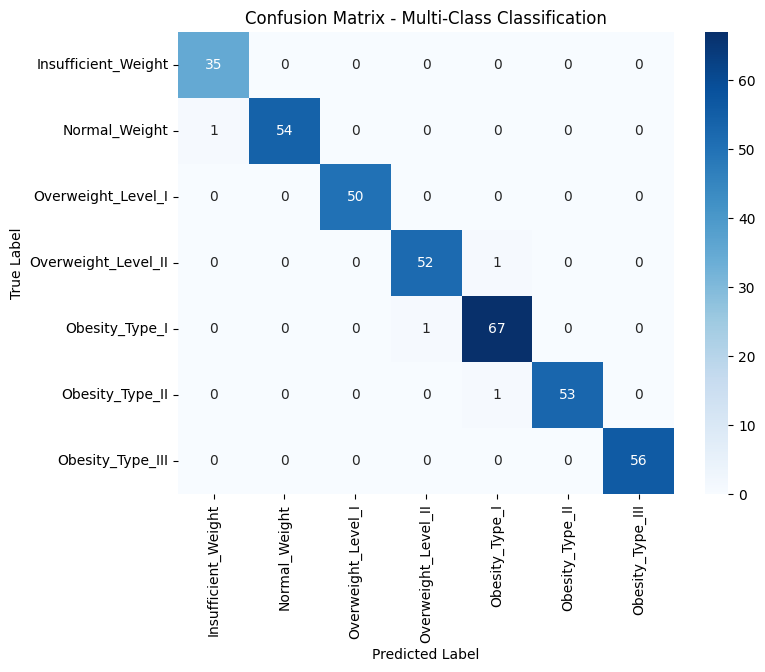

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.97      1.00      0.99        35
      Normal_Weight       1.00      0.98      0.99        55
 Overweight_Level_I       1.00      1.00      1.00        50
Overweight_Level_II       0.98      0.98      0.98        53
     Obesity_Type_I       0.97      0.99      0.98        68
    Obesity_Type_II       1.00      0.98      0.99        54
   Obesity_Type_III       1.00      1.00      1.00        56

           accuracy                           0.99       371
          macro avg       0.99      0.99      0.99       371
       weighted avg       0.99      0.99      0.99       371

Train ACC : 1.00
F1 (weighted) : 0.99
ACC cross val 5 : 0.97
AUC (ROC Curve) : 1.00


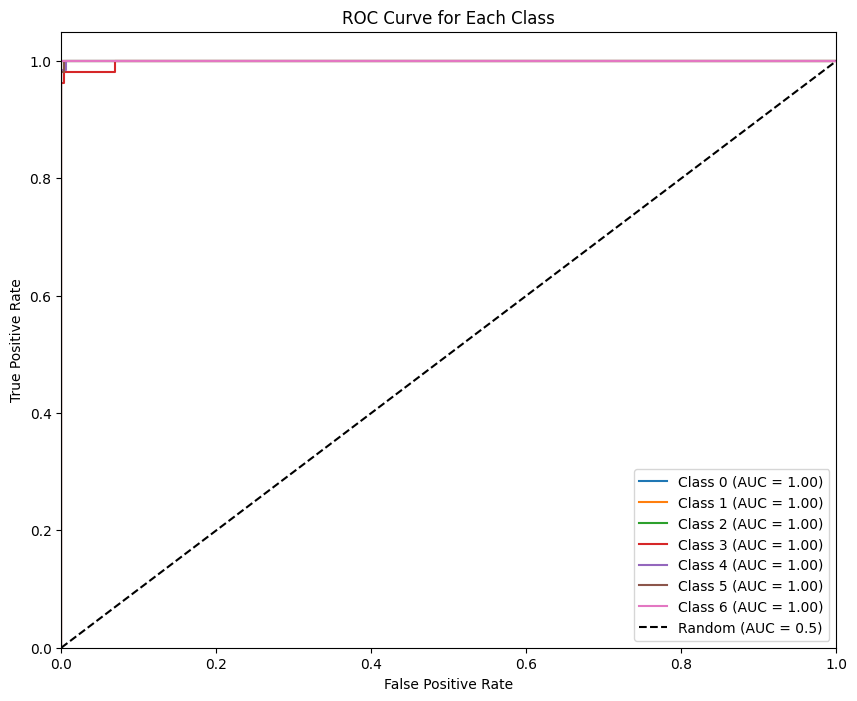

In [ ]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Pastikan data X_train, X_test, y_train, y_test sudah ada
# Encode target labels (Obesity) for multi-class
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Inisialisasi model XGBoost untuk multi-class
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    objective='multi:softmax',  # Update objective to multi-class
    num_class=len(label_encoder.classes_),  # Specify number of classes
    eval_metric='mlogloss'
)

# Manual Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = []

for train_idx, val_idx in cv.split(X_train, y_train_encoded):
    X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_cv, y_val_cv = y_train_encoded[train_idx], y_train_encoded[val_idx]

    # Fit model
    xgb_model.fit(X_train_cv, y_train_cv)
    y_val_pred = xgb_model.predict(X_val_cv)
    score = accuracy_score(y_val_cv, y_val_pred)
    cross_val_scores.append(score)

# Rata-rata hasil cross-validation
cross = np.mean(cross_val_scores)

# Fit ulang model pada semua data training
xgb_model.fit(X_train, y_train_encoded)

# Prediksi pada data testing
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)  # Output probabilities for ROC AUC

# Evaluasi
accuracy = accuracy_score(y_test_encoded, y_pred)
f1 = f1_score(y_test_encoded, y_pred, average='weighted')  # Weighted F1 score
auc = roc_auc_score(y_test_encoded, y_pred_proba, multi_class='ovr', average='weighted')  # Multi-class AUC

# Akurasi pada data training
train_pred = xgb_model.predict(X_train)
tacc = accuracy_score(y_train_encoded, train_pred)

# Confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)

target_classes = {
    0: "Insufficient_Weight",
    1: "Normal_Weight",
    2: "Overweight_Level_I",
    3: "Overweight_Level_II",
    4: "Obesity_Type_I",
    5: "Obesity_Type_II",
    6: "Obesity_Type_III"
}
# Ensure the target names are properly aligned with label encoder classes
target_names = [target_classes[i] for i in range(len(target_classes))]

# Visualisasi matriks konfusi
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Multi-Class Classification')
plt.show()

print("Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=target_names))
print('=============================================================')
print(f'Train ACC : {tacc:.2f}')
print('=============================================================')
print(f'F1 (weighted) : {f1:.2f}')
print('=============================================================')
print(f'ACC cross val 5 : {cross:.2f}')
print('=============================================================')
print(f'AUC (ROC Curve) : {auc:.2f}')
print('=============================================================')

# Binarize the output labels for multi-class ROC AUC
y_test_binarized = label_binarize(y_test_encoded, classes=np.arange(len(label_encoder.classes_)))
y_pred_proba_binarized = xgb_model.predict_proba(X_test)

from sklearn.metrics import auc as auc_func  # Explicitly import auc as auc_func

# Initialize dictionary to store AUC values
roc_auc_scores = {}

# Calculate ROC curve and AUC for each class
fpr, tpr = {}, {}

for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba_binarized[:, i])
    roc_auc_scores[i] = auc_func(fpr[i], tpr[i])  # Use auc_func to avoid conflict

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc_scores[i]:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='lower right')
plt.show()

###KNN

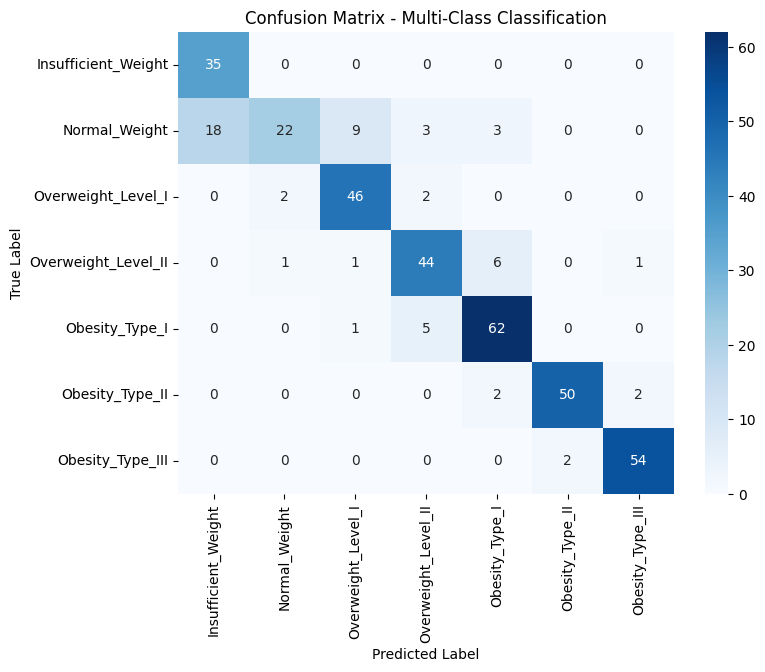

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.66      1.00      0.80        35
      Normal_Weight       0.88      0.40      0.55        55
 Overweight_Level_I       0.81      0.92      0.86        50
Overweight_Level_II       0.81      0.83      0.82        53
     Obesity_Type_I       0.85      0.91      0.88        68
    Obesity_Type_II       0.96      0.93      0.94        54
   Obesity_Type_III       0.95      0.96      0.96        56

           accuracy                           0.84       371
          macro avg       0.85      0.85      0.83       371
       weighted avg       0.86      0.84      0.83       371

Train ACC : 0.91
F1 (weighted) : 0.83
ACC cross val 5 : 0.84
AUC (ROC Curve) : 0.97


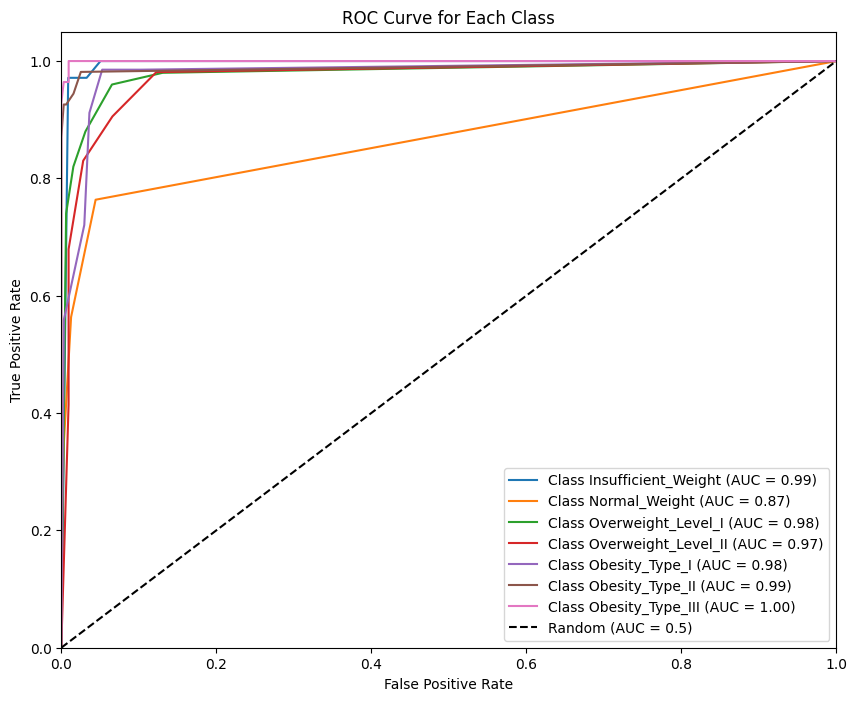

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Encode target labels (Obesity) for multi-class
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Inisialisasi model KNN untuk multi-class
knn_model = KNeighborsClassifier(n_neighbors=5)  # Pilih jumlah tetangga (k) yang diinginkan

# Manual Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = []

for train_idx, val_idx in cv.split(X_train, y_train_encoded):
    X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_cv, y_val_cv = y_train_encoded[train_idx], y_train_encoded[val_idx]

    # Fit model
    knn_model.fit(X_train_cv, y_train_cv)
    y_val_pred = knn_model.predict(X_val_cv)
    score = accuracy_score(y_val_cv, y_val_pred)
    cross_val_scores.append(score)

# Rata-rata hasil cross-validation
cross = np.mean(cross_val_scores)

# Fit ulang model pada semua data training
knn_model.fit(X_train, y_train_encoded)

# Prediksi pada data testing
y_pred = knn_model.predict(X_test)

# Evaluasi
accuracy = accuracy_score(y_test_encoded, y_pred)
f1 = f1_score(y_test_encoded, y_pred, average='weighted')  # Weighted F1 score

# Akurasi pada data training
train_pred = knn_model.predict(X_train)
tacc = accuracy_score(y_train_encoded, train_pred)

# Confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)

# Output hasil evaluasi
target_classes = {
    0: "Insufficient_Weight",
    1: "Normal_Weight",
    2: "Overweight_Level_I",
    3: "Overweight_Level_II",
    4: "Obesity_Type_I",
    5: "Obesity_Type_II",
    6: "Obesity_Type_III"
}
# Ensure the target names are properly aligned with label encoder classes
target_names = [target_classes[i] for i in range(len(target_classes))]

# Visualisasi matriks konfusi
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Multi-Class Classification')
plt.show()

overall_auc = np.mean(list(roc_auc_scores.values()))

print("Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=target_names))
print('=============================================================')
print(f'Train ACC : {tacc:.2f}')
print('=============================================================')
print(f'F1 (weighted) : {f1:.2f}')
print('=============================================================')
print(f'ACC cross val 5 : {cross:.2f}')
print('=============================================================')
print(f'AUC (ROC Curve) : {overall_auc:.2f}')
print('=============================================================')

# Binarize the output labels for multi-class ROC AUC
y_test_binarized = label_binarize(y_test_encoded, classes=np.arange(len(label_encoder.classes_)))
y_pred_proba_binarized = knn_model.predict_proba(X_test)

# Calculate ROC curve and AUC for each class
fpr, tpr = {}, {}
roc_auc_scores = {}

for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba_binarized[:, i])
    roc_auc_scores[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'Class {target_names[i]} (AUC = {roc_auc_scores[i]:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='lower right')
plt.show()